# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **23.10.2023**

Мягкий дедлайн: **08.11.23 23:59**

Жесткий дедлайн: **12.11.23 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

$\frac{2}{\ell}X^T\left( y - Xw \right)=0$

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [1]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        return (1/x.shape[0])*np.dot((y-np.dot(x, self.w)).T, (y-np.dot(x, self.w)))
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return np.dot(x, self.w)

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [2]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        diff = - self.lr()*gradient
        self.w = self.w + diff
        return diff
    
    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return -(2/x.shape[0])*np.dot(x.T, (y-np.dot(x, self.w)))


https://contest.yandex.ru/contest/54610/problems/A/

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [3]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch_indices = np.random.choice(x.shape[0], size=self.batch_size, replace=False)
        batch = x[batch_indices]
        return -(2/batch.shape[0])*np.dot(batch.T, (y[batch_indices]-np.dot(batch, self.w)))

https://contest.yandex.ru/contest/54610/problems/B/

### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [4]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha*self.h+self.lr()*gradient
        self.w = self.w - self.h
        return - self.h

https://contest.yandex.ru/contest/54610/problems/C/

### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](adam_meme.png)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [5]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1*self.m + (1-self.beta_1)*gradient
        self.v = self.beta_2*self.v + (1-self.beta_2)*(gradient**2)
        m_hat = self.m / (1 - self.beta_1**self.iteration)
        v_hat = self.v / (1 - self.beta_2**self.iteration)
        diff = - (self.lr()*m_hat)/(np.sqrt(v_hat) + self.eps)
        self.w = self.w + diff
        return diff

https://contest.yandex.ru/contest/54610/problems/D/

## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение 

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [6]:
from __future__ import annotations

from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent

In [7]:
class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        for it in range(0, self.max_iter):
            self.loss_history.append(self.descent.calc_loss(x, y))
            diff = self.descent.step(x, y)
            if np.linalg.norm(diff)**2 < self.tolerance:
                break
            elif np.nan in diff:
                break
        self.loss_history.append(self.descent.calc_loss(x, y))
                
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)


https://contest.yandex.ru/contest/54610/problems/E/

## Задание 3. Проверка кода (0 баллов)

In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

import numpy as np

from descents import get_descent
from linear_regression import LinearRegression

In [10]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [11]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [12]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/54610/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**:


* **StochasticDescent**:


* **MomentumDescent**:


* **Adam**:


* **LinearRegression**:

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [312]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [313]:
data = pd.read_csv('autos.csv')

In [314]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

### распределение целевой переменной:

95-quantile: 22000.0


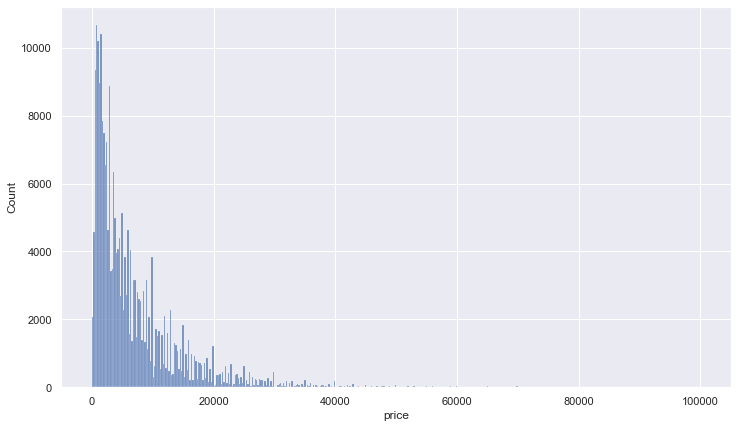

In [315]:
plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='price')
q_95 = data['price'].quantile(0.95)
print(f'95-quantile: {q_95}');

В целевой переменной присутствует очень много выбросов, поэтому их лучше удалить. 

In [316]:
data1 = data.drop(index = data[data['price'] > q_95].index)

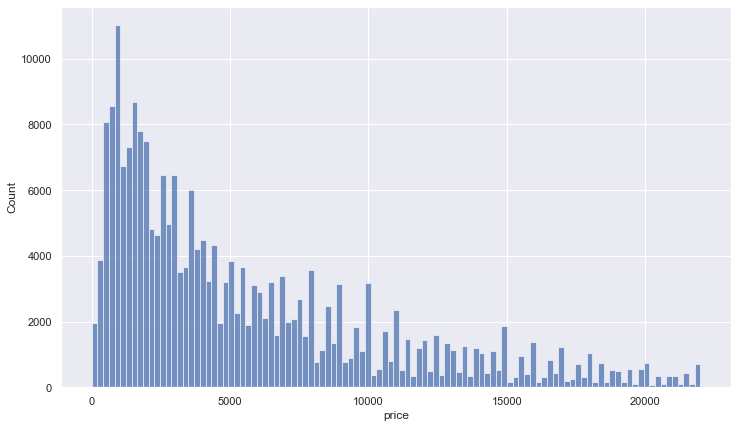

In [317]:
plt.figure(figsize=(12, 7))
sns.histplot(data=data1, x='price');

Теперь в хвостах у нас не так много данных.

In [318]:
data1['price'] = np.log(data1['price'])

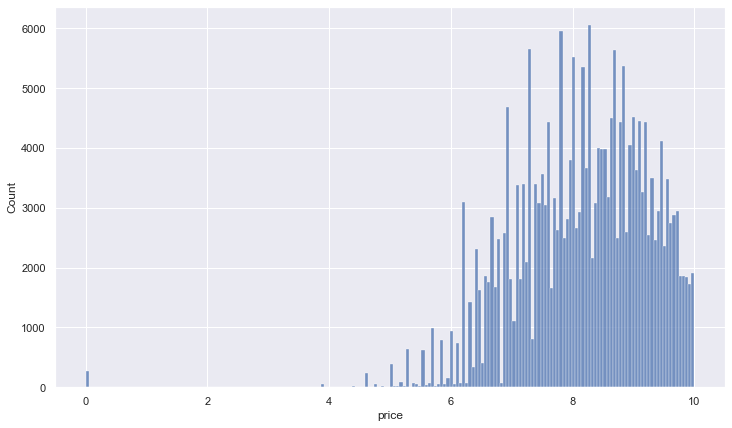

In [319]:
plt.figure(figsize=(12, 7))
sns.histplot(data=data1, x='price');

In [320]:
categorical = ['brand', 'model', 'vehicleType', 'fuelType', 'gearbox']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = ['notRepairedDamage'] # порядковый (нет лучше, чем да)

# YOUR CODE (EDA):

### Посмотрим на категориальные признаки:

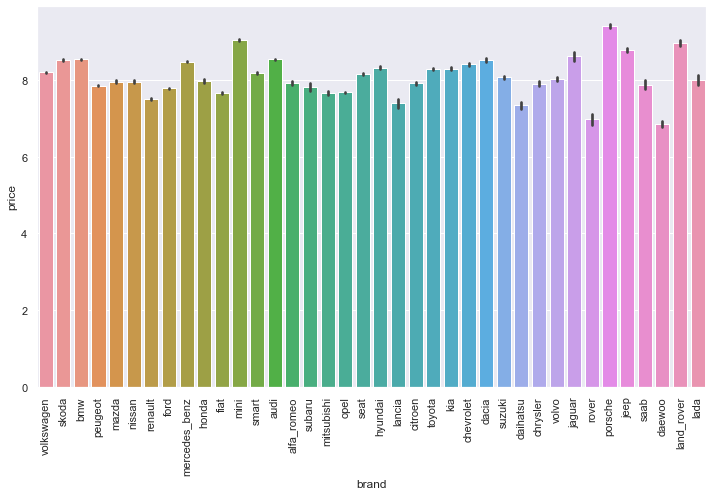

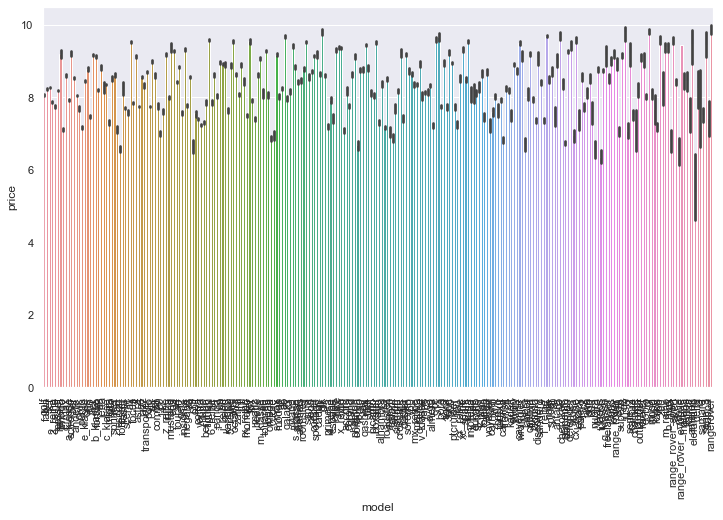

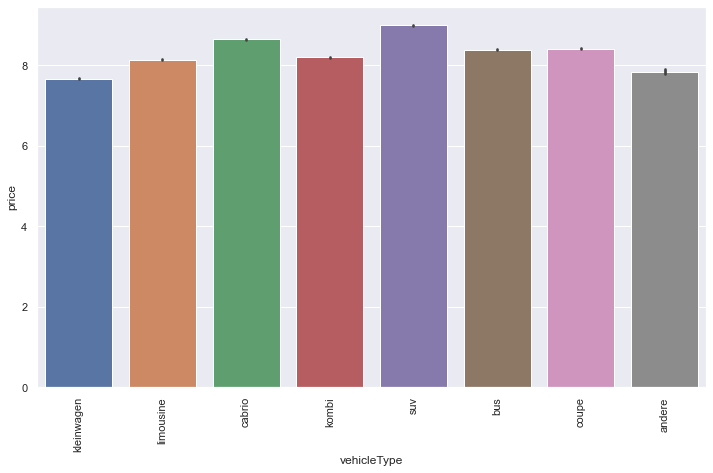

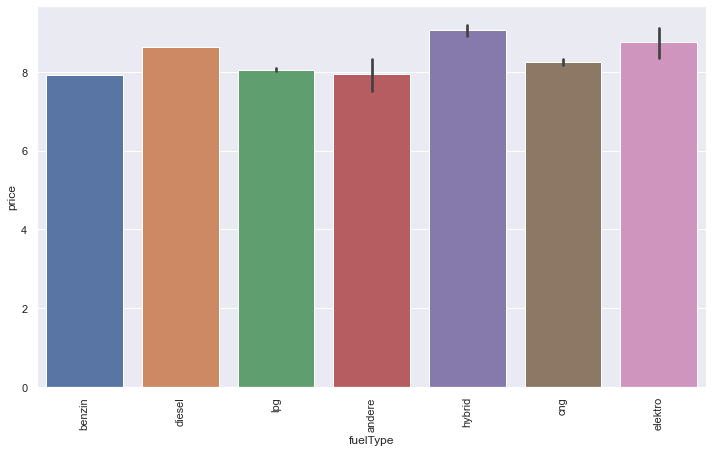

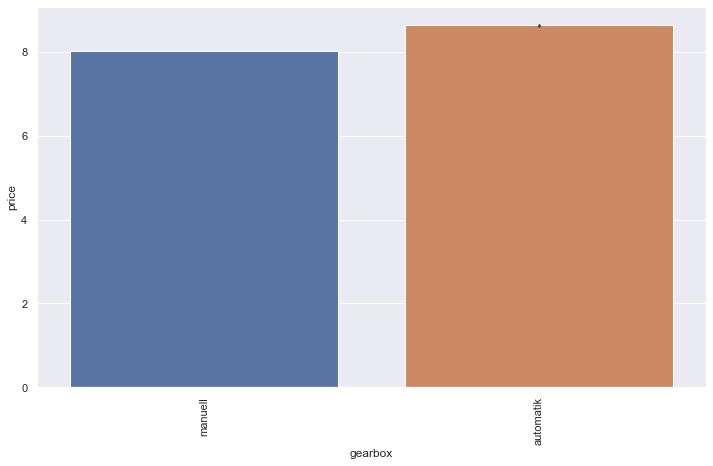

In [321]:
for i, c in zip(range(1, 6), categorical):
    plt.figure(figsize=(12, 7))
    sns.barplot(data=data1, y='price', x=c)
    plt.xticks(rotation=90)

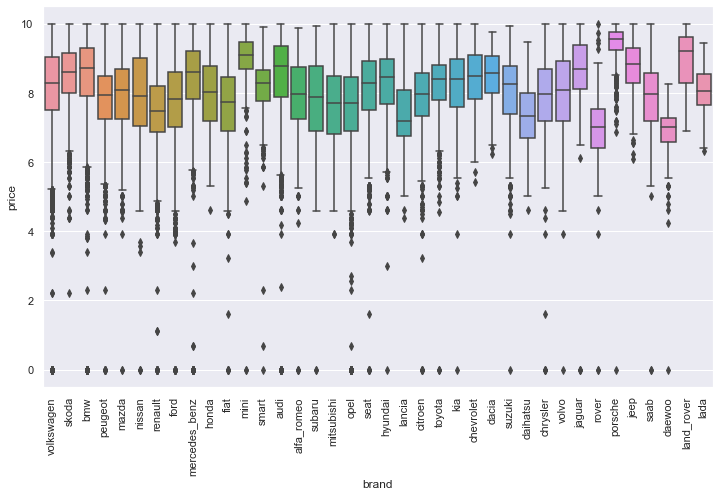

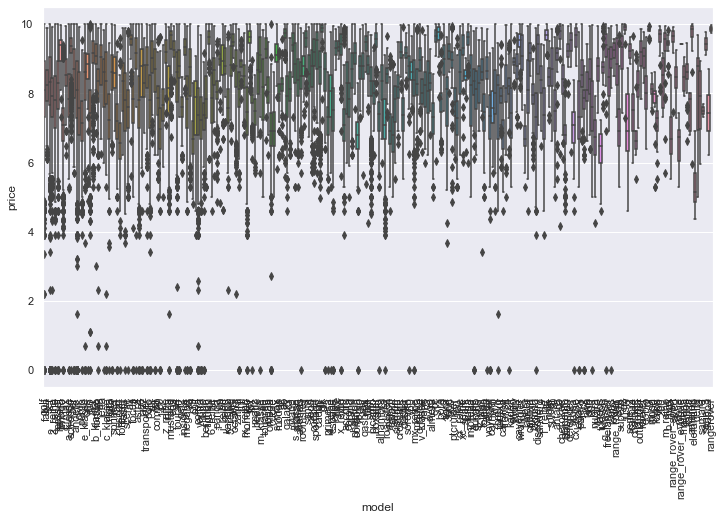

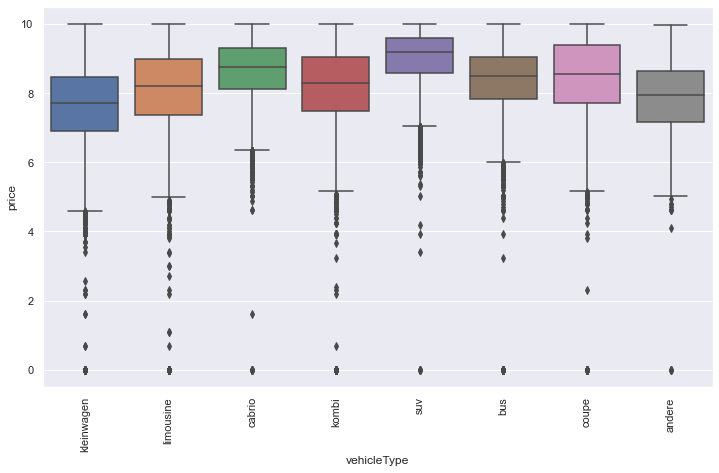

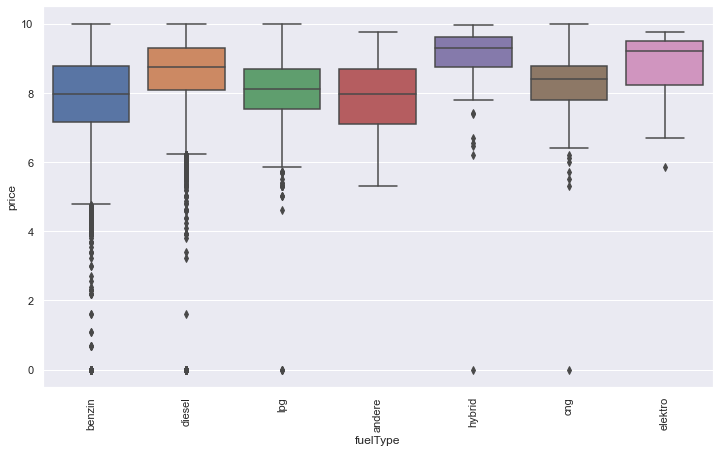

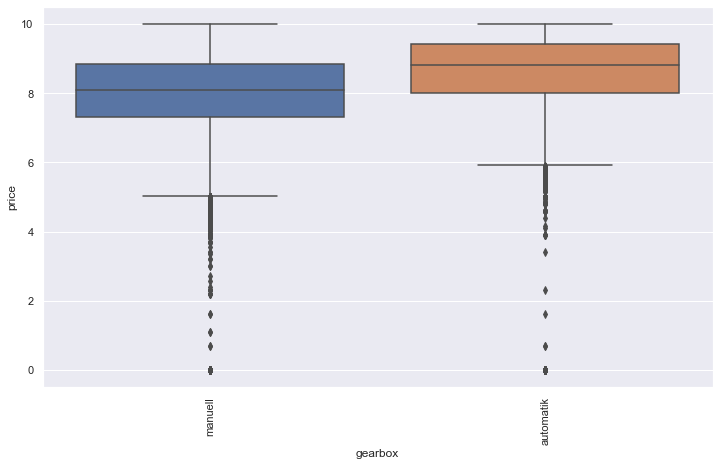

In [322]:
for i, c in zip(range(1, 6), categorical):
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=data1, y='price', x=c)
    plt.xticks(rotation=90)

Есть некоторые категории, которые указывают более высокую цену автомобиля. Например, такие бренды, как porsche, mini и land rover являются самыми дорогими, как по среднему, так и по мендианному значениям. Дороже всего стоят машины типа suv, а kleinwagen - самые дешевые. Hybrid и elektro указывают на более высокую цену в категории fuelType. Также automatik дороже manuell. 

### Числовые признаки:

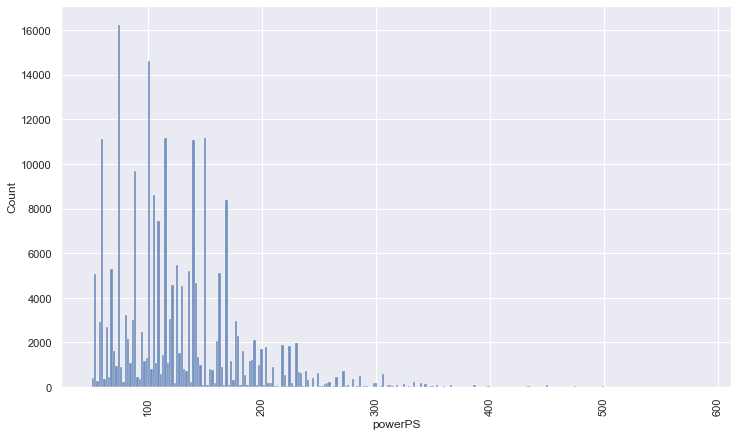

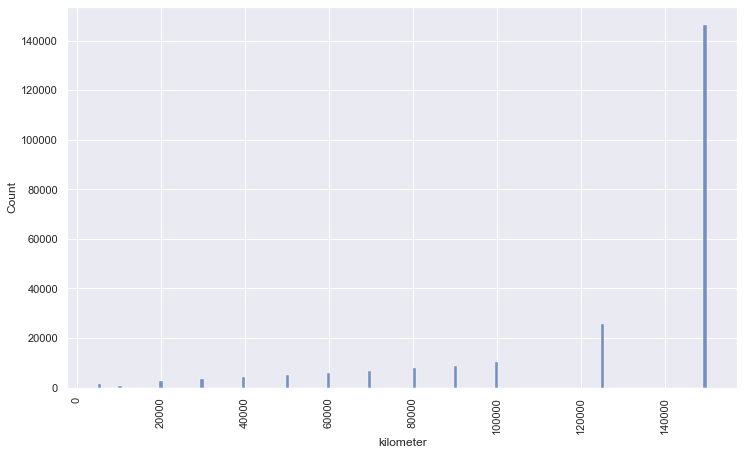

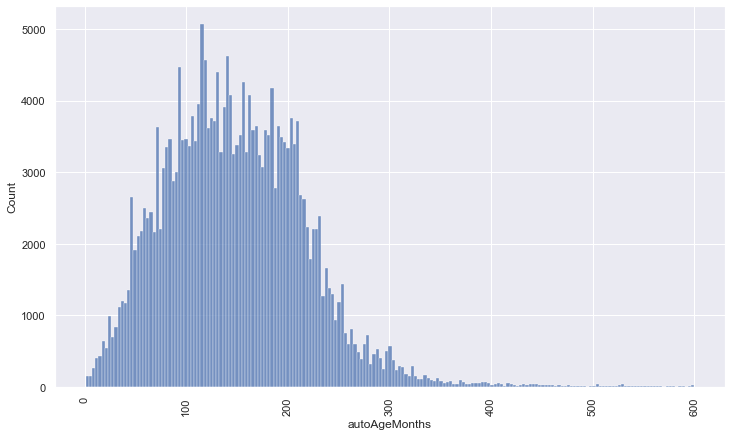

In [323]:
for i, c in zip(range(1, 5), numeric):
    plt.figure(figsize=(12, 7))
    sns.histplot(data=data1, x=c)
    plt.xticks(rotation=90);

По распределению числовых признаков наблюдаем, что признаки powerPS и autoAgeMonths имеют достаточно длинные хвосты, а kilometer больше походит на категориальный признак, потому что, по всей видимости, содержит только числа округленные до 10000.

<Figure size 864x504 with 0 Axes>

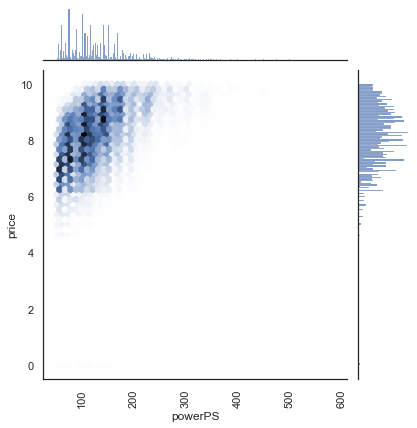

<Figure size 864x504 with 0 Axes>

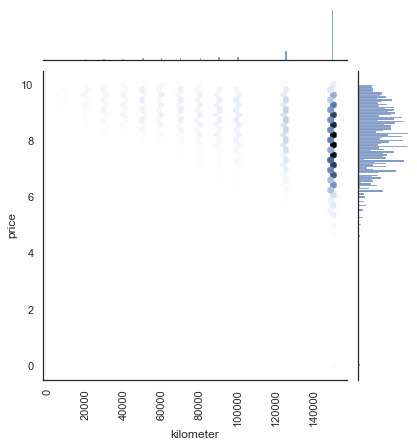

<Figure size 864x504 with 0 Axes>

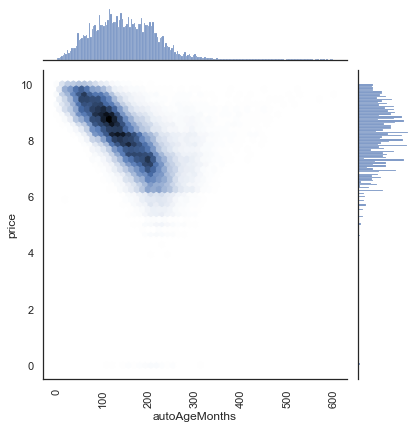

In [324]:
for i, c in zip(range(1, 4), numeric):
    with sns.axes_style('white'):
        plt.figure(figsize=(12, 7))
        sns.jointplot(data=data1, y='price', x=c, kind='hex')
        plt.xticks(rotation=90);

Из scatter plotов видим, что price зависит от powerPS положительно, то есть при увеличении powerPS price скорее всего вырастет, 
а от autoAgeMonths price, наоборот, зависит отрицательно, то есть при увеличении autoAgeMonths price скорее всего упадет. 

Попробуем проанализировать признак kilometer, как категориальный. 

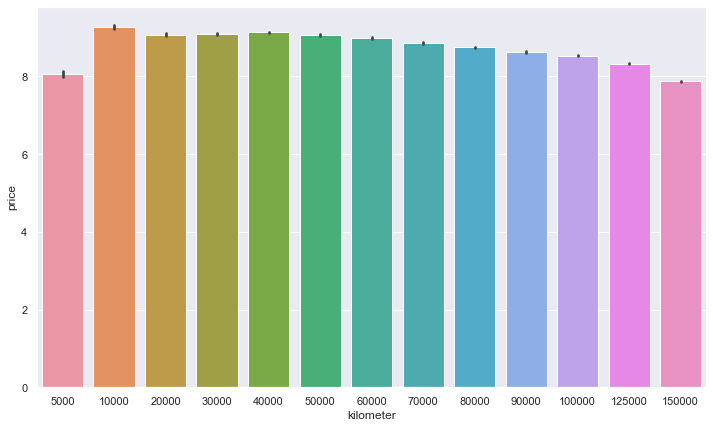

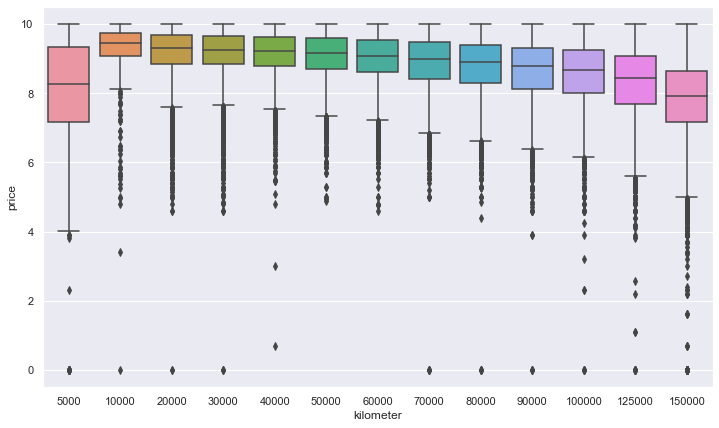

In [325]:
plt.figure(figsize=(12, 7))
sns.barplot(data=data1, x='kilometer', y='price')
plt.figure(figsize=(12, 7))
sns.boxplot(data=data1, x='kilometer', y='price');

Теперь четко видно, что при увеличении пробега, цена на машину падает. Будем считать kilometer **категориальным признаком**. 

### Оставшиеся признаки:

Остался один признак - notRepairedDamage, которые является порядковым, потому что "нет", в данном случае, лучше, чем "да". Анализировать его будем на подобии категориального. 

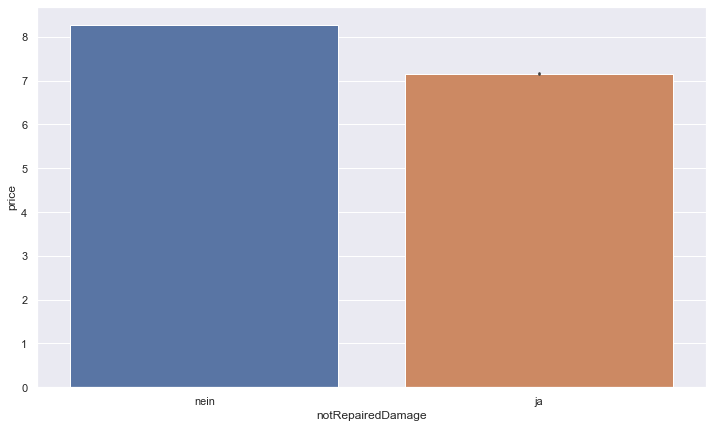

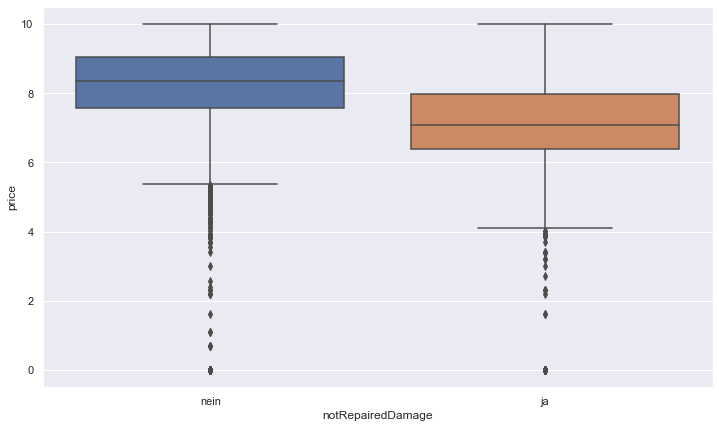

In [326]:
plt.figure(figsize=(12, 7))
sns.barplot(data=data1, x='notRepairedDamage', y='price')
plt.figure(figsize=(12, 7))
sns.boxplot(data=data1, x='notRepairedDamage', y='price');

Очевидно, что если в автомобиле есть неисправность, которая еще не устранена (вариант "ja"), то она будет стоить дешевле, что и видно из графиков. 

Для простоты будем считать notRepairedDamage тоже категориальным:

In [327]:
categorical = ['brand', 'model', 'vehicleType', 'fuelType', 'gearbox', 'kilometer', 'notRepairedDamage']
numeric = ['powerPS', 'autoAgeMonths']
other = []

In [328]:
data1['bias'] = 1
other += ['bias']

x = data1[categorical + numeric + other]
y = data1['price']

In [329]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

In [330]:
import scipy

In [331]:
x = np.array(scipy.sparse.csc_matrix.todense(x))
y = np.array(y)

In [339]:
np.random.seed(0)

from sklearn.model_selection import train_test_split

x_train, X, y_train, Y = train_test_split(x, y, train_size=0.8, test_size=0.2)
x_test, x_cv, y_test, y_cv = train_test_split(X, Y, test_size = 0.5,train_size =0.5)

In [340]:
x_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.46434299,
        -0.16933526,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.08214077,
        -0.59616388,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.95109276,
         0.10098952,  1.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.43427196,
        -0.26892861,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.3442368 ,
        -0.29738385,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  3.26116482,
        -0.46811529,  1.        ]])

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [600]:
lambdas = np.linspace(0.001, 1.9, 40)
lambdas

array([1.00000000e-03, 4.96923077e-02, 9.83846154e-02, 1.47076923e-01,
       1.95769231e-01, 2.44461538e-01, 2.93153846e-01, 3.41846154e-01,
       3.90538462e-01, 4.39230769e-01, 4.87923077e-01, 5.36615385e-01,
       5.85307692e-01, 6.34000000e-01, 6.82692308e-01, 7.31384615e-01,
       7.80076923e-01, 8.28769231e-01, 8.77461538e-01, 9.26153846e-01,
       9.74846154e-01, 1.02353846e+00, 1.07223077e+00, 1.12092308e+00,
       1.16961538e+00, 1.21830769e+00, 1.26700000e+00, 1.31569231e+00,
       1.36438462e+00, 1.41307692e+00, 1.46176923e+00, 1.51046154e+00,
       1.55915385e+00, 1.60784615e+00, 1.65653846e+00, 1.70523077e+00,
       1.75392308e+00, 1.80261538e+00, 1.85130769e+00, 1.90000000e+00])

In [601]:
from sklearn.metrics import r2_score

descent_config = {
    'descent_name': 'full',
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321
    }
}

results = {'lambdas':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for l in lambdas:
    descent_config['kwargs']['lambda_'] = l
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results['lambdas'].append(l)
    results['iters'].append(iters)
    results['losses_train'].append(loss_train)
    results['losses_test'].append(loss_test)
    results['R2'].append(r2)

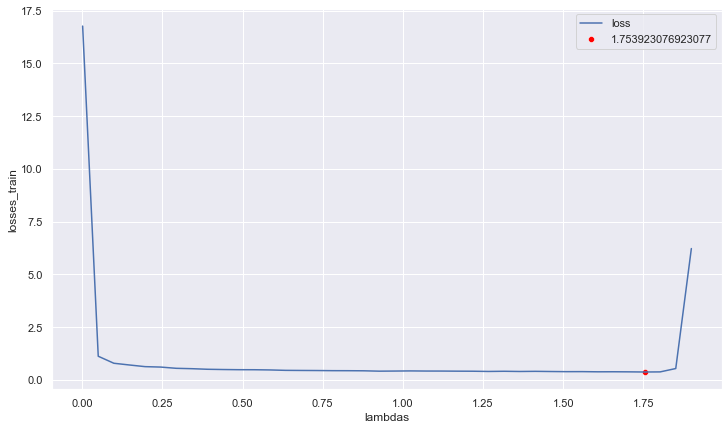

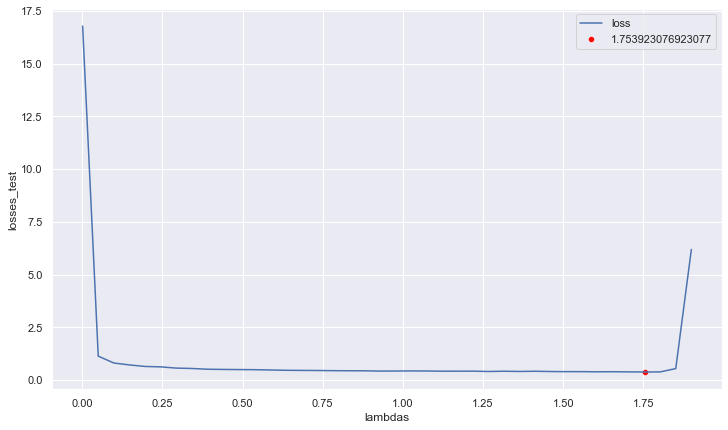

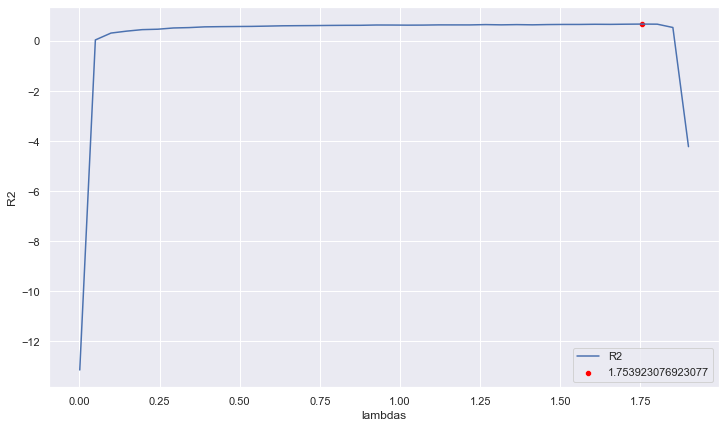

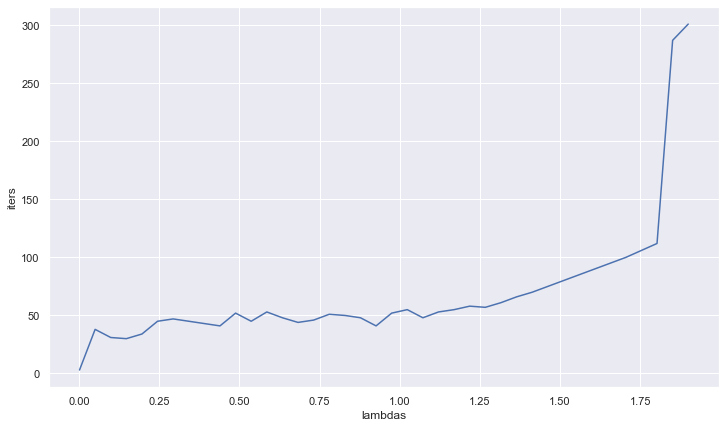

In [602]:
results_full = pd.DataFrame(results)
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_train')
min_loss_train = results_full['losses_train'].min()
best_lambda_loss_train = results_full[results_full['losses_train'] == min_loss_train]['lambdas']
sns.scatterplot(y=min_loss_train, x=best_lambda_loss_train, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_train.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_test')
min_loss_test = results_full['losses_test'].min()
best_lambda_loss_test = results_full[results_full['losses_test'] == min_loss_test]['lambdas']
sns.scatterplot(y=min_loss_test, x=best_lambda_loss_test, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_test.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='R2')
max_r2 = results_full['R2'].max()
best_lambda_r2 = results_full[results_full['R2'] == max_r2]['lambdas']
sns.scatterplot(y=max_r2, x=best_lambda_r2, color='red')
plt.legend(labels=['R2', f'{best_lambda_r2.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='iters');

Для 'full' лучшая лямбда: 1.75

In [344]:
descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321
    }
}

results_SGD = {'lambdas':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for l in lambdas:
    descent_config['kwargs']['lambda_'] = l
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results_SGD['lambdas'].append(l)
    results_SGD['iters'].append(iters)
    results_SGD['losses_train'].append(loss_train)
    results_SGD['losses_test'].append(loss_test)
    results_SGD['R2'].append(r2)

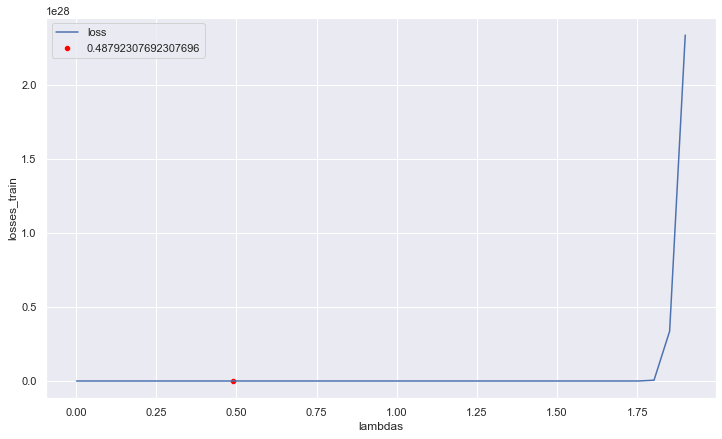

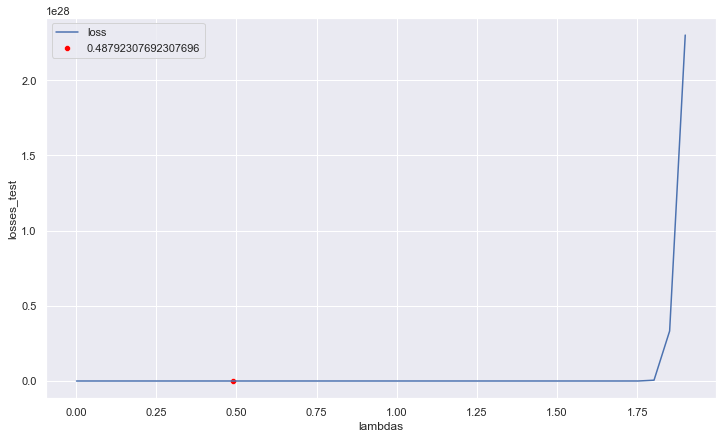

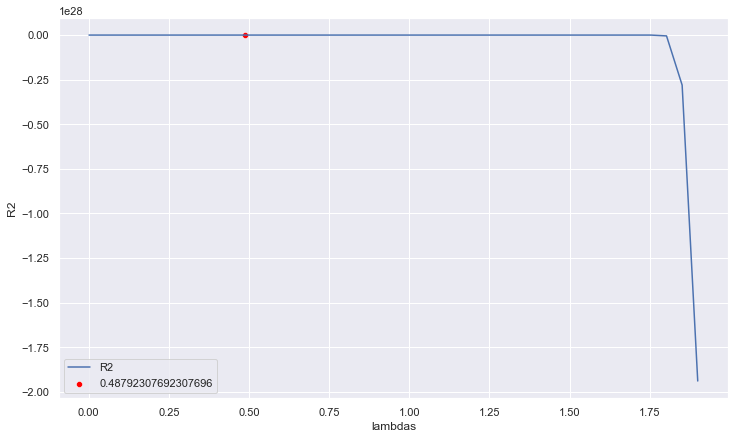

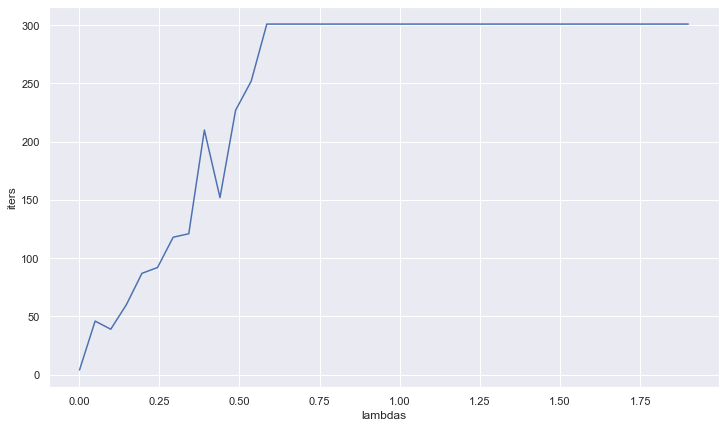

In [345]:
results_full = pd.DataFrame(results_SGD)
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_train')
min_loss_train = results_full['losses_train'].min()
best_lambda_loss_train = results_full[results_full['losses_train'] == min_loss_train]['lambdas']
sns.scatterplot(y=min_loss_train, x=best_lambda_loss_train, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_train.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_test')
min_loss_test = results_full['losses_test'].min()
best_lambda_loss_test = results_full[results_full['losses_test'] == min_loss_test]['lambdas']
sns.scatterplot(y=min_loss_test, x=best_lambda_loss_test, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_test.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='R2')
max_r2 = results_full['R2'].max()
best_lambda_r2 = results_full[results_full['R2'] == max_r2]['lambdas']
sns.scatterplot(y=max_r2, x=best_lambda_r2, color='red')
plt.legend(labels=['R2', f'{best_lambda_r2.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='iters');

Для 'stochastic' лучшая лямбда: 0.49

In [346]:
descent_config = {
    'descent_name': 'momentum',
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321
    }
}

results_M = {'lambdas':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for l in lambdas:
    descent_config['kwargs']['lambda_'] = l
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results_M['lambdas'].append(l)
    results_M['iters'].append(iters)
    results_M['losses_train'].append(loss_train)
    results_M['losses_test'].append(loss_test)
    results_M['R2'].append(r2)

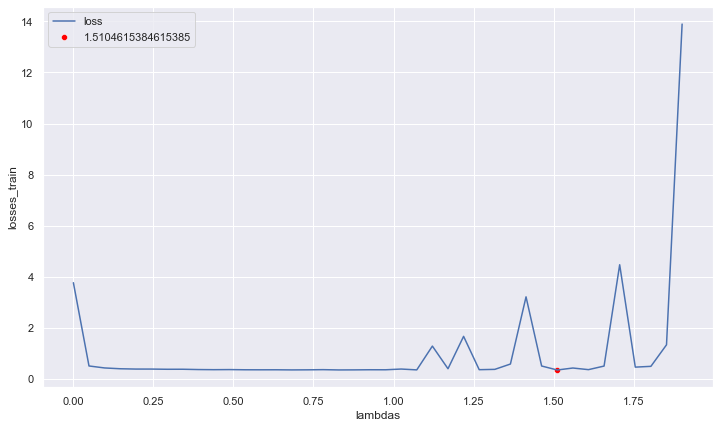

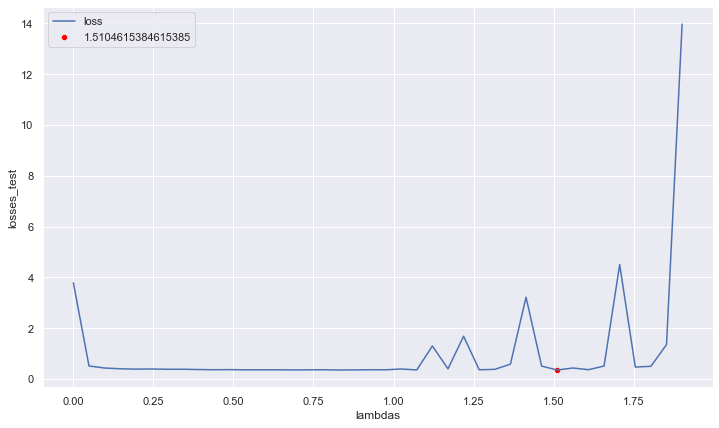

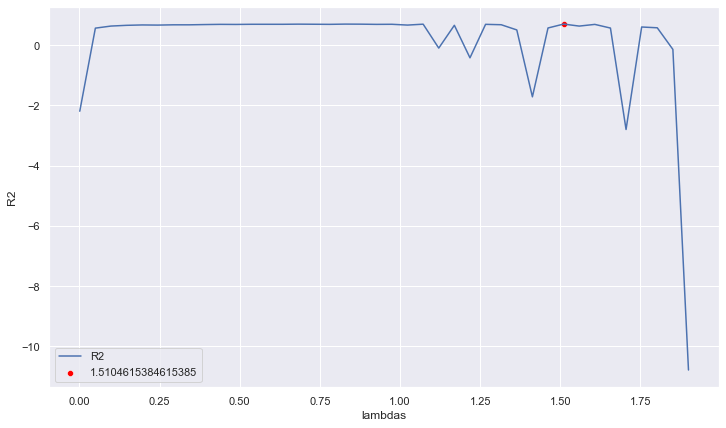

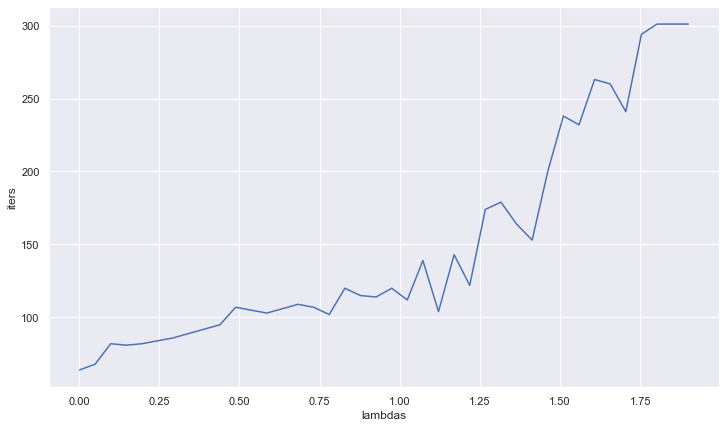

In [347]:
results_full = pd.DataFrame(results_M)
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_train')
min_loss_train = results_full['losses_train'].min()
best_lambda_loss_train = results_full[results_full['losses_train'] == min_loss_train]['lambdas']
sns.scatterplot(y=min_loss_train, x=best_lambda_loss_train, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_train.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_test')
min_loss_test = results_full['losses_test'].min()
best_lambda_loss_test = results_full[results_full['losses_test'] == min_loss_test]['lambdas']
sns.scatterplot(y=min_loss_test, x=best_lambda_loss_test, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_test.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='R2')
max_r2 = results_full['R2'].max()
best_lambda_r2 = results_full[results_full['R2'] == max_r2]['lambdas']
sns.scatterplot(y=max_r2, x=best_lambda_r2, color='red')
plt.legend(labels=['R2', f'{best_lambda_r2.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='iters');

Для 'momentum' лучшая лямбда: 1.51

In [348]:
lambdas_adam = np.logspace(0.001, 5, 50)
lambdas_adam

array([1.00230524e+00, 1.26771144e+00, 1.60339608e+00, 2.02796859e+00,
       2.56496612e+00, 3.24415832e+00, 4.10319776e+00, 5.18970721e+00,
       6.56391979e+00, 8.30201805e+00, 1.05003574e+01, 1.32808077e+01,
       1.67975096e+01, 2.12454193e+01, 2.68711167e+01, 3.39864750e+01,
       4.29859501e+01, 5.43684484e+01, 6.87649841e+01, 8.69736618e+01,
       1.10003920e+02, 1.39132494e+02, 1.75974192e+02, 2.22571415e+02,
       2.81507387e+02, 3.56049356e+02, 4.50329723e+02, 5.69575133e+02,
       7.20396225e+02, 9.11154106e+02, 1.15242387e+03, 1.45758085e+03,
       1.84354211e+03, 2.33170428e+03, 2.94912973e+03, 3.73004684e+03,
       4.71774751e+03, 5.96698714e+03, 7.54702016e+03, 9.54543926e+03,
       1.20730313e+04, 1.52699190e+04, 1.93133292e+04, 2.44274173e+04,
       3.08956943e+04, 3.90767438e+04, 4.94241007e+04, 6.25113940e+04,
       7.90641474e+04, 1.00000000e+05])

In [349]:
descent_config = {
    'descent_name': 'adam',
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321
    }
}

results_Adam = {'lambdas':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for l in lambdas_adam:
    descent_config['kwargs']['lambda_'] = l
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results_Adam['lambdas'].append(l)
    results_Adam['iters'].append(iters)
    results_Adam['losses_train'].append(loss_train)
    results_Adam['losses_test'].append(loss_test)
    results_Adam['R2'].append(r2)

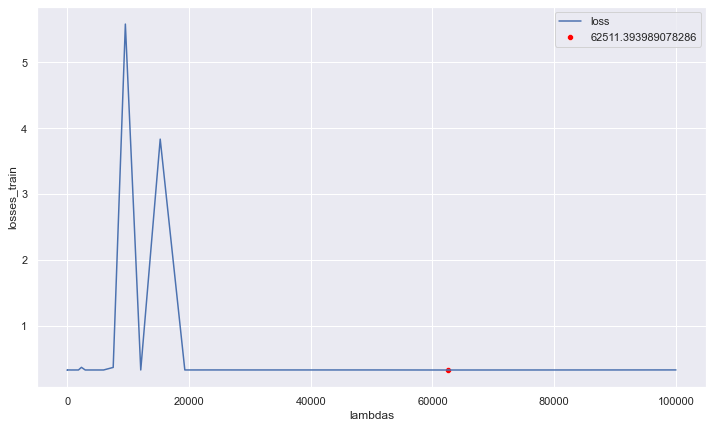

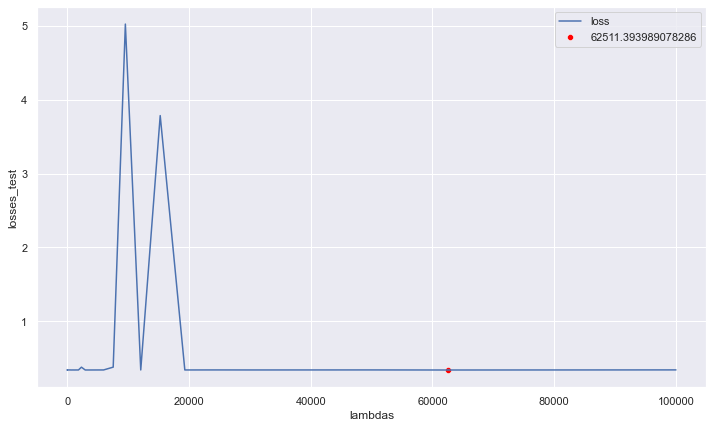

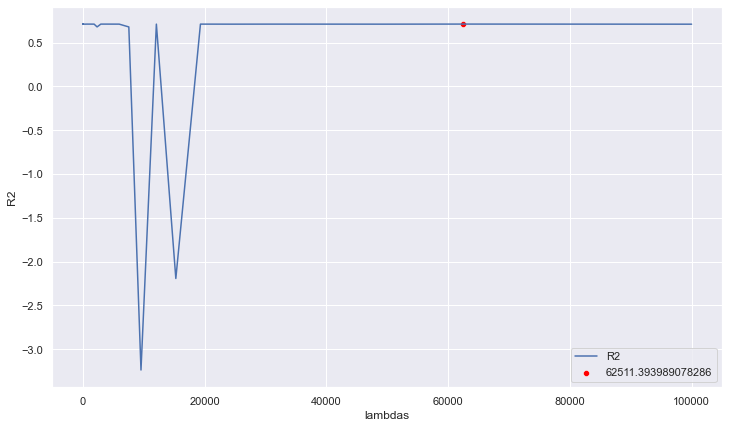

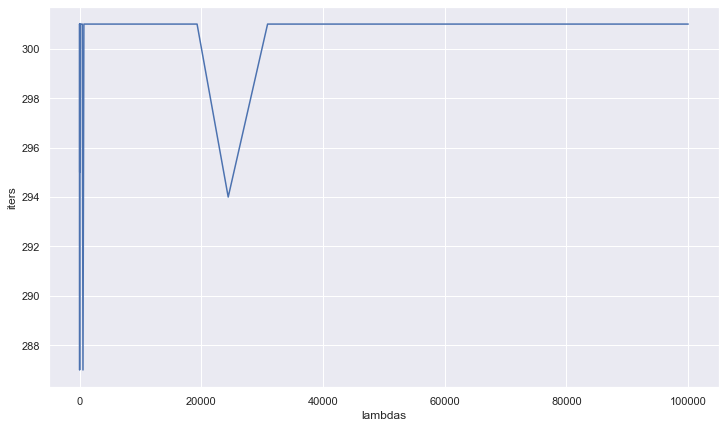

In [350]:
results_full = pd.DataFrame(results_Adam)
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_train')
min_loss_train = results_full['losses_train'].min()
best_lambda_loss_train = results_full[results_full['losses_train'] == min_loss_train]['lambdas']
sns.scatterplot(y=min_loss_train, x=best_lambda_loss_train, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_train.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='losses_test')
min_loss_test = results_full['losses_test'].min()
best_lambda_loss_test = results_full[results_full['losses_test'] == min_loss_test]['lambdas']
sns.scatterplot(y=min_loss_test, x=best_lambda_loss_test, color='red')
plt.legend(labels=['loss', f'{best_lambda_loss_test.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='R2')
max_r2 = results_full['R2'].max()
best_lambda_r2 = results_full[results_full['R2'] == max_r2]['lambdas']
sns.scatterplot(y=max_r2, x=best_lambda_r2, color='red')
plt.legend(labels=['R2', f'{best_lambda_r2.values[0]}'])
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_full, x='lambdas', y='iters');

Для 'adam' лучшая лямбда: 62511

In [352]:
best_lambdas = {'full' : 1.75, 'stochastic' : 0.49, 'momentum' : 1.51, 'adam' : 62511}

### Задание 5.2. Сравнение методов (1 балла) 

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

In [353]:
descent_config = {
    'descent_name': 'model name',
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321
    }
}

results_models = {}

for name, l in zip(best_lambdas.keys(), best_lambdas.values()):
    descent_config['descent_name'] = name
    descent_config['kwargs']['lambda_'] = l
    regression = LinearRegression(descent_config)
    regression.fit(x_train, y_train)
    losses = regression.loss_history
    results_models[name] = losses

In [359]:
results_full = pd.Series(results_models['full'])
results_stochastic = pd.Series(results_models['stochastic'])
results_momentum = pd.Series(results_models['momentum'])
results_adam = pd.Series(results_models['adam'])

In [361]:
full_min = results_full.min()
full_iter = results_full[results_full == full_min].index[0]
stochastic_min = results_stochastic.min()
stochastic_iter = results_stochastic[results_stochastic == stochastic_min].index[0]
momentum_min = results_momentum.min()
momentum_iter = results_momentum[results_momentum == momentum_min].index[0]
adam_min = results_adam.min()
adam_iter = results_adam[results_adam == adam_min].index[0]
print(f'full min: {full_min}, iter: {full_iter}')
print(f'stochastic min: {stochastic_min}, iter: {stochastic_iter}')
print(f'momentum min: {momentum_min}, iter: {momentum_iter}')
print(f'adam min: {adam_min}, iter: {adam_iter}')

full min: 0.3699588808425001, iter: 105
stochastic min: 0.4333383699311144, iter: 224
momentum min: 0.33093456339321575, iter: 201
adam min: 0.32139528928443467, iter: 267


In [368]:
full_last = results_full.tail(1).values[0]
stochastic_last = results_stochastic.tail(1).values[0]
momentum_last = results_momentum.tail(1).values[0]
adam_last = results_adam.tail(1).values[0]
full_iters = results_full.shape[0]
stochastic_iters = results_stochastic.shape[0]
momentum_iters = results_momentum.shape[0]
adam_iters = results_adam.shape[0]
print(f'full end loss value: {full_last}, number of iters: {full_iters}')
print(f'stochastic end loss value: {stochastic_last}, number of iters: {stochastic_iters}')
print(f'momentum end loss value: {momentum_last}, number of iters: {momentum_iters}')
print(f'adam end loss value: {adam_last}, number of iters: {adam_iters}')

full end loss value: 0.3699588808425001, number of iters: 106
stochastic end loss value: 0.4345379674022051, number of iters: 227
momentum end loss value: 0.4721395880022376, number of iters: 214
adam end loss value: 0.3409241363960536, number of iters: 273


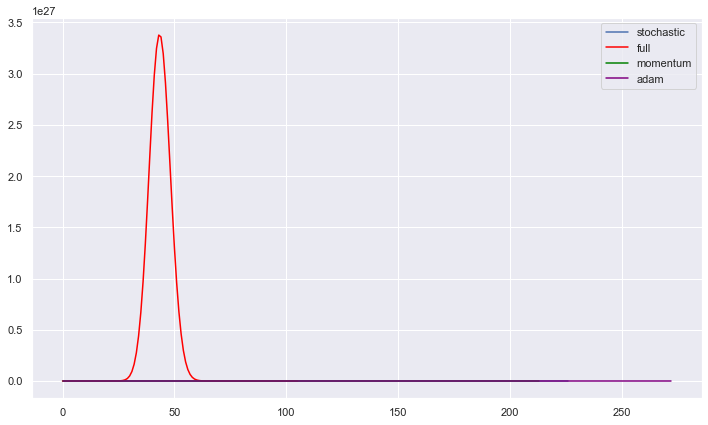

In [369]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_stochastic.index, y=results_stochastic.values)
sns.lineplot(x=results_full.index, y=results_full.values, color='red')
sns.lineplot(x=results_momentum.index, y=results_momentum.values, color='green')
sns.lineplot(x=results_adam.index, y=results_adam.values, color='purple')
plt.legend(labels=['stochastic', 'full', 'momentum', 'adam']);

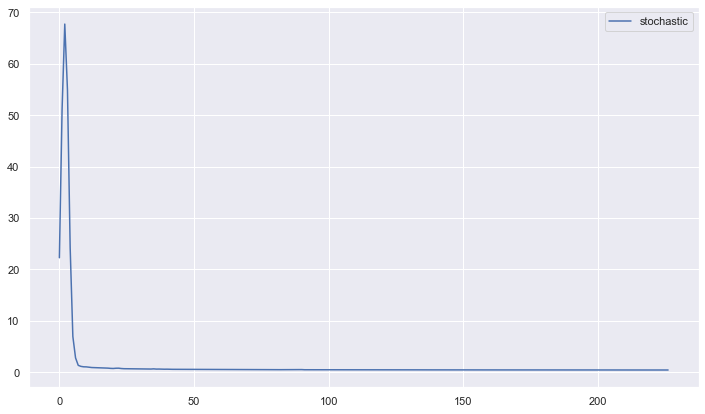

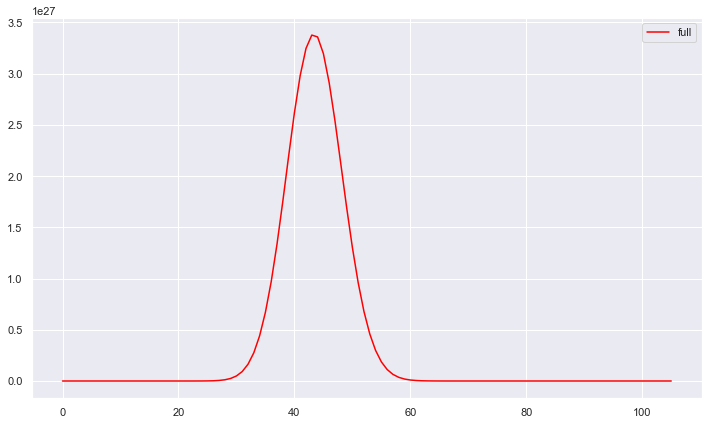

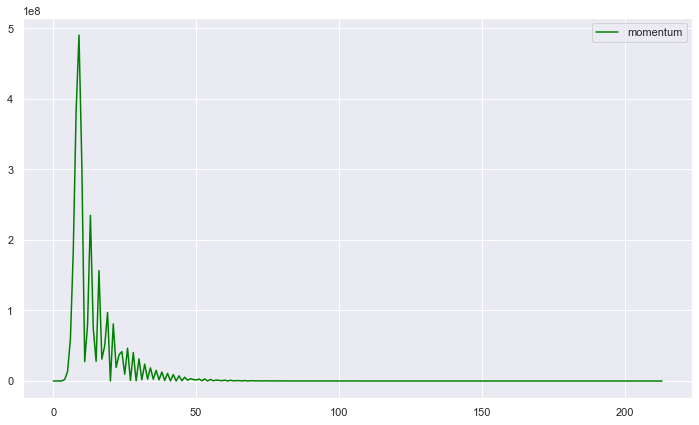

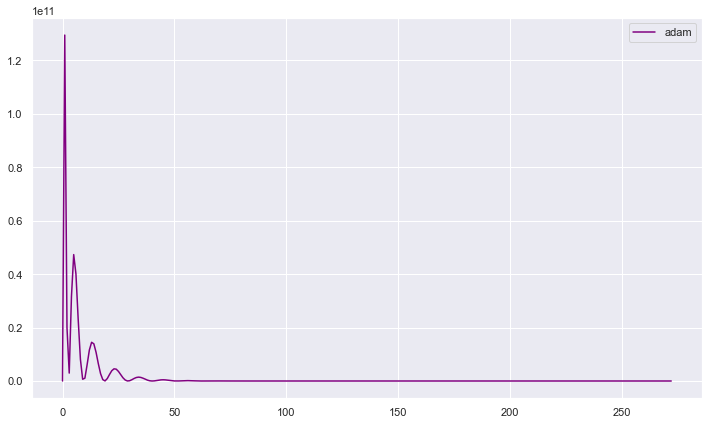

In [376]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_stochastic.index, y=results_stochastic.values)
plt.legend(labels=['stochastic'])
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_full.index, y=results_full.values, color='red')
plt.legend(labels=['full'])
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_momentum.index, y=results_momentum.values, color='green')
plt.legend(labels=['momentum'])
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_adam.index, y=results_adam.values, color='purple')
plt.legend(labels=['adam']);

Если смотреть на значения ошибок в конце работы градиентов, то градиенты идут в следующем порядке, от лучшего к худшему: adam, full, stochastic, momentum. Хотя, если смотреть на минимально достигаемую ошибку, то тогда будет слудующая картина: adam, momentum, full, stochastic. Если смотреть на графики, то ошибка в full в какой-то момент становиться огромной, однако в дальнейшем сходиться к примерно таким же значениям, как и другие градиентные спуски. 

`### ваше решение тут ###`

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска. 

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [427]:
from timeit import default_timer as timer

In [440]:
batch_sizes = np.arange(5, 500, 10)

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'lambda_': best_lambdas['stochastic'],
        'dimension': 321,
        'batch_size': 'batch'
    }
}

results_batch_SGD = {'batch_size':list(), 'time':list(), 'iters':list()}

for batch in batch_sizes:
    descent_config['kwargs']['batch_size'] = batch
    regression = LinearRegression(descent_config)
    print(1)
    start = timer()
    regression.fit(x_train, y_train)
    end = timer()
    time = end - start
    iters = len(regression.loss_history)
    results_batch_SGD['batch_size'].append(batch)
    results_batch_SGD['time'].append(time)
    results_batch_SGD['iters'].append(iters)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [442]:
df_batch_SGD = pd.DataFrame(results_batch_SGD)
df_batch_SGD

,batch_size,time,iters
0,5,6.580025,301
1,15,6.622644,301
2,25,6.625529,301
3,35,5.208283,239
4,45,5.785765,262
5,55,4.627261,208
6,65,5.373275,242
7,75,4.456933,199
8,85,3.772726,173
9,95,3.870114,175


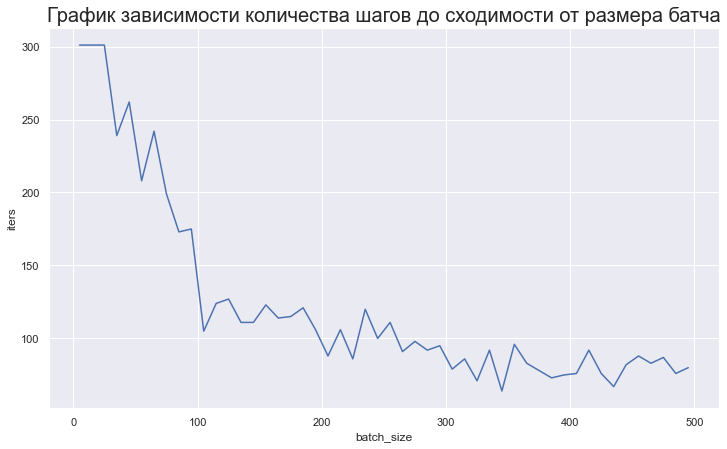

In [448]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_batch_SGD, x='batch_size', y='iters')
plt.title('График зависимости количества шагов до сходимости от размера батча', fontsize=20);

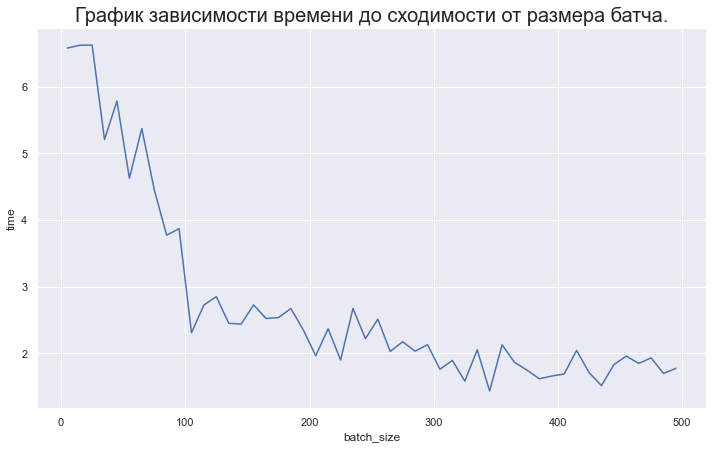

In [450]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_batch_SGD, x='batch_size', y='time')
plt.title('График зависимости времени до сходимости от размера батча.', fontsize=20);

**Выводы**: чем больше размер батча, тем меньше в среднем итераций требуется для сходимости, и тем меньше время сходимости.

`### ваше решение тут ###`

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**:

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [458]:
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient: np.ndarray = self.w
        
        l2_gradient[-1] = 0
        
        return super().calc_gradient(x, y) + l2_gradient * self.mu

https://contest.yandex.ru/contest/54610/problems/F/?success=96172441#528867/2021_10_11/d2PBaMv7Cj

In [520]:
lambdas = np.linspace(0.001, 1.9, 10)
mus = np.linspace(0.01, 1, 10)

unique_combinations = []
 
for i in range(len(lambdas)):
    for j in range(len(mus)):
        unique_combinations.append((lambdas[i], mus[j]))

In [521]:
descent_config = {
    'descent_name': 'full',
    'regularized':True,
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321,
        'mu':'some mu'
    }
}

results = {'combs':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for params in unique_combinations:
    l, mu = params
    descent_config['kwargs']['lambda_'] = l
    descent_config['kwargs']['mu'] = mu
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results['combs'].append(params)
    results['iters'].append(iters)
    results['losses_train'].append(loss_train)
    results['losses_test'].append(loss_test)
    results['R2'].append(r2)

<Figure size 864x864 with 0 Axes>

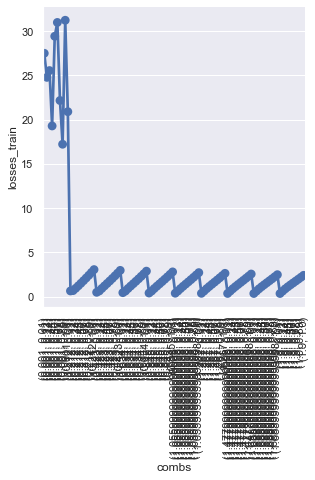

<Figure size 864x864 with 0 Axes>

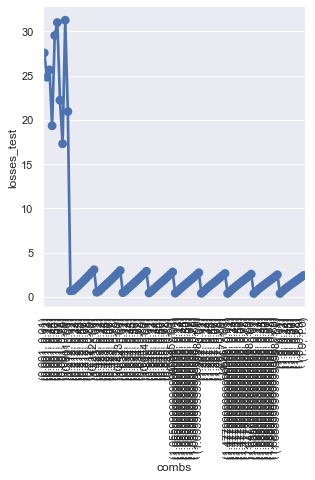

<Figure size 864x864 with 0 Axes>

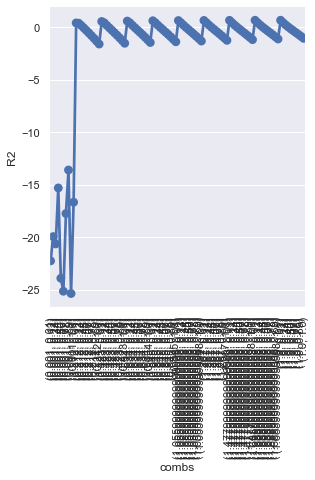

<Figure size 864x864 with 0 Axes>

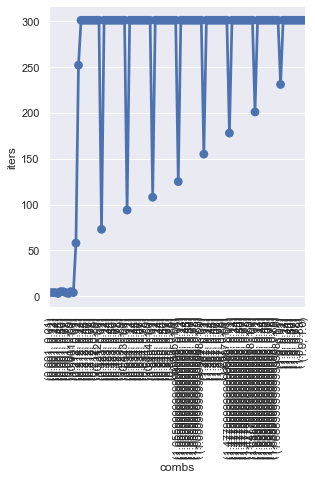

In [522]:
results_full = pd.DataFrame(results)
plt.figure(figsize=(12, 12))
sns.catplot(data=results_full, x='combs', y='losses_train', kind="point")
plt.xticks(rotation=90)
min_loss_train = results_full['losses_train'].min()
best_comb_loss_train = results_full[results_full['losses_train'] == min_loss_train]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_full, x='combs', y='losses_test', kind="point")
plt.xticks(rotation=90)
min_loss_test = results_full['losses_test'].min()
best_comb_loss_test = results_full[results_full['losses_test'] == min_loss_test]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_full, x='combs', y='R2', kind='point')
plt.xticks(rotation=90)
max_r2 = results_full['R2'].max()
best_comb_r2 = results_full[results_full['R2'] == max_r2]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_full, x='combs', y='iters', kind='point')
plt.xticks(rotation=90);

In [523]:
best_comb_loss_train

90    (1.9, 0.01)
Name: combs, dtype: object

In [524]:
best_comb_loss_test

90    (1.9, 0.01)
Name: combs, dtype: object

In [525]:
best_comb_r2

90    (1.9, 0.01)
Name: combs, dtype: object

Для full лучшая лямбда для full: 1.9, лучшая mu: 0.01

In [526]:
descent_config = {
    'descent_name': 'stochastic',
    'regularized':True,
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321,
        'mu':'some mu'
    }
}

results = {'combs':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for params in unique_combinations:
    l, mu = params
    descent_config['kwargs']['lambda_'] = l
    descent_config['kwargs']['mu'] = mu
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results['combs'].append(params)
    results['iters'].append(iters)
    results['losses_train'].append(loss_train)
    results['losses_test'].append(loss_test)
    results['R2'].append(r2)

<Figure size 864x864 with 0 Axes>

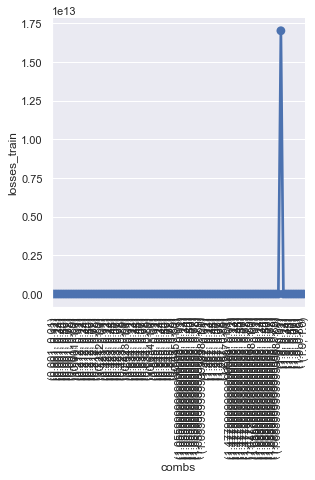

<Figure size 864x864 with 0 Axes>

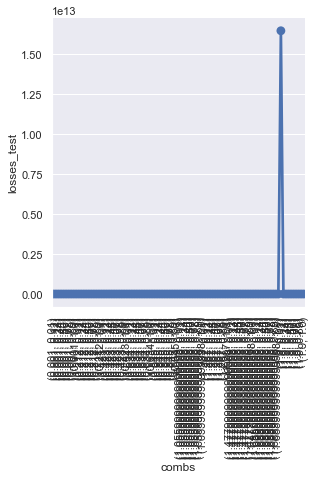

<Figure size 864x864 with 0 Axes>

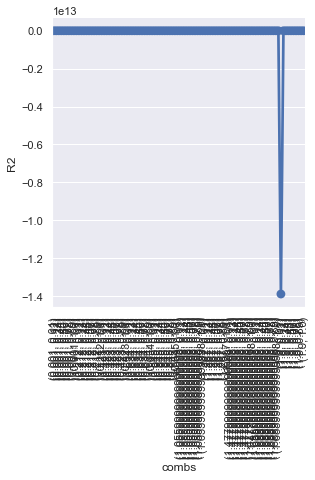

<Figure size 864x864 with 0 Axes>

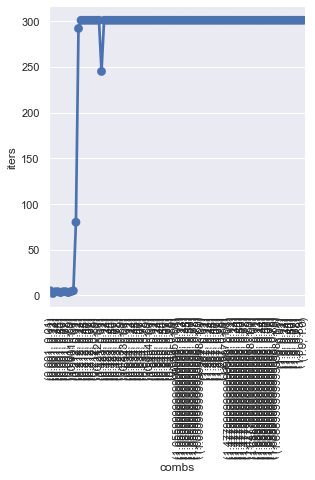

In [527]:
results_SGD = pd.DataFrame(results)
plt.figure(figsize=(12, 12))
sns.catplot(data=results_SGD, x='combs', y='losses_train', kind="point")
plt.xticks(rotation=90)
min_loss_train = results_SGD['losses_train'].min()
best_comb_loss_train = results_SGD[results_SGD['losses_train'] == min_loss_train]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_SGD, x='combs', y='losses_test', kind="point")
plt.xticks(rotation=90)
min_loss_test = results_SGD['losses_test'].min()
best_comb_loss_test = results_SGD[results_SGD['losses_test'] == min_loss_test]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_SGD, x='combs', y='R2', kind='point')
plt.xticks(rotation=90)
max_r2 = results_SGD['R2'].max()
best_comb_r2 = results_SGD[results_SGD['R2'] == max_r2]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_SGD, x='combs', y='iters', kind='point')
plt.xticks(rotation=90);

In [528]:
best_comb_loss_train

30    (0.634, 0.01)
Name: combs, dtype: object

In [530]:
best_comb_loss_test

30    (0.634, 0.01)
Name: combs, dtype: object

In [531]:
best_comb_r2

30    (0.634, 0.01)
Name: combs, dtype: object

Для stochastic лучшая лямбда: 0.634, лучшая mu: 0.01

In [532]:
descent_config = {
    'descent_name': 'momentum',
    'regularized':True,
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321,
        'mu':'some mu'
    }
}

results = {'combs':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for params in unique_combinations:
    l, mu = params
    descent_config['kwargs']['lambda_'] = l
    descent_config['kwargs']['mu'] = mu
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results['combs'].append(params)
    results['iters'].append(iters)
    results['losses_train'].append(loss_train)
    results['losses_test'].append(loss_test)
    results['R2'].append(r2)

<Figure size 864x864 with 0 Axes>

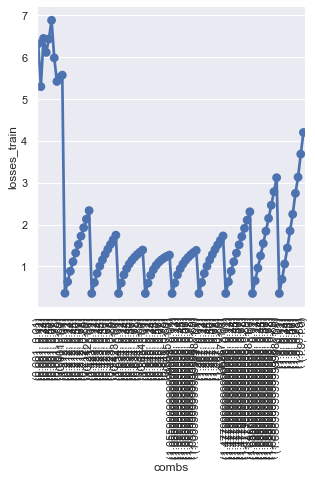

<Figure size 864x864 with 0 Axes>

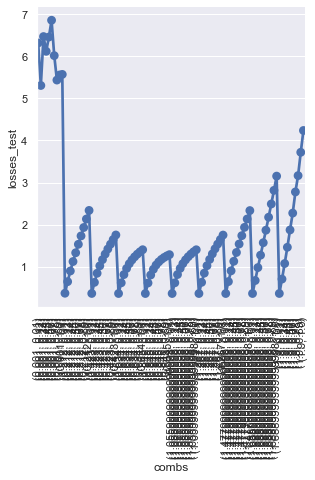

<Figure size 864x864 with 0 Axes>

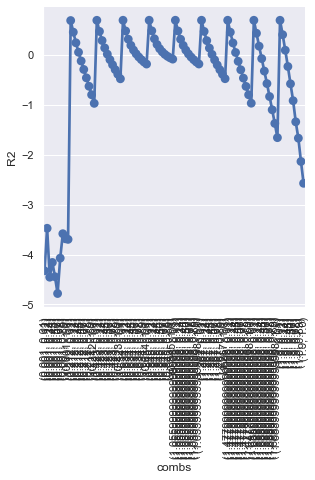

<Figure size 864x864 with 0 Axes>

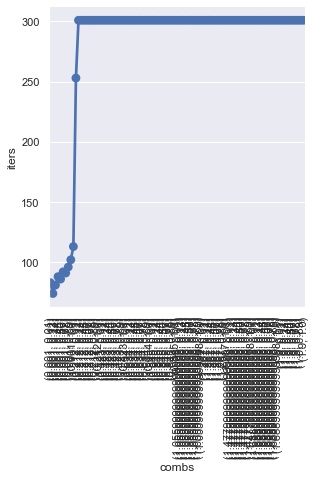

In [533]:
results_momentum = pd.DataFrame(results)
plt.figure(figsize=(12, 12))
sns.catplot(data=results_momentum, x='combs', y='losses_train', kind="point")
plt.xticks(rotation=90)
min_loss_train = results_momentum['losses_train'].min()
best_comb_loss_train = results_momentum[results_momentum['losses_train'] == min_loss_train]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_momentum, x='combs', y='losses_test', kind="point")
plt.xticks(rotation=90)
min_loss_test = results_momentum['losses_test'].min()
best_comb_loss_test = results_momentum[results_momentum['losses_test'] == min_loss_test]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_momentum, x='combs', y='R2', kind='point')
plt.xticks(rotation=90)
max_r2 = results_momentum['R2'].max()
best_comb_r2 = results_momentum[results_momentum['R2'] == max_r2]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_momentum, x='combs', y='iters', kind='point')
plt.xticks(rotation=90);

In [534]:
best_comb_loss_train

40    (0.845, 0.01)
Name: combs, dtype: object

In [535]:
best_comb_loss_test

50    (1.0559999999999998, 0.01)
Name: combs, dtype: object

In [536]:
best_comb_r2

50    (1.0559999999999998, 0.01)
Name: combs, dtype: object

Для momentum лучшая лямбда: 1.05, лучшая mu: 0.01

In [537]:
descent_config = {
    'descent_name': 'adam',
    'regularized':True,
    'kwargs': {
        'lambda_': 'lambda',
        'dimension': 321,
        'mu':'some mu'
    }
}

results = {'combs':list(), 'iters':list(), 'losses_train':list(), 'losses_test':list(), 'R2':list()}

for params in unique_combinations:
    l, mu = params
    descent_config['kwargs']['lambda_'] = l
    descent_config['kwargs']['mu'] = mu
    regression = LinearRegression(descent_config)
    regression.fit(x_cv, y_cv)
    iters = len(regression.loss_history)
    loss_train = regression.calc_loss(x_train, y_train)
    loss_test = regression.calc_loss(x_test, y_test)
    predict = regression.predict(x_test)
    r2 = r2_score(y_test, predict)
    results['combs'].append(params)
    results['iters'].append(iters)
    results['losses_train'].append(loss_train)
    results['losses_test'].append(loss_test)
    results['R2'].append(r2)

<Figure size 864x864 with 0 Axes>

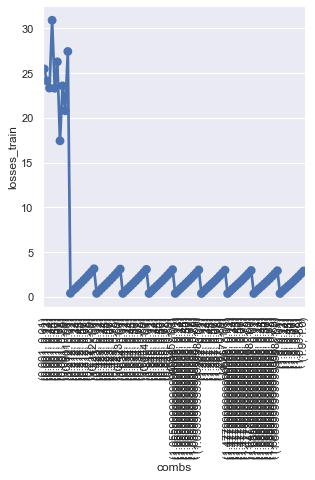

<Figure size 864x864 with 0 Axes>

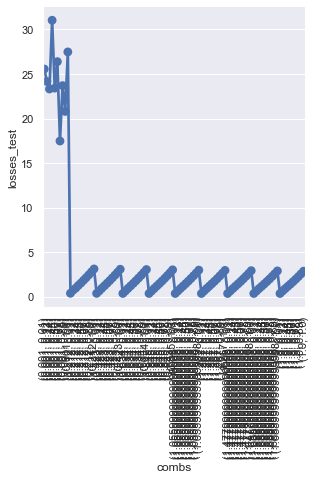

<Figure size 864x864 with 0 Axes>

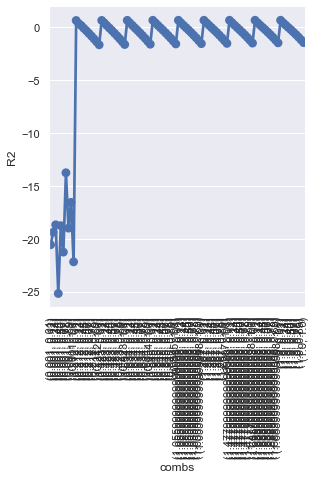

<Figure size 864x864 with 0 Axes>

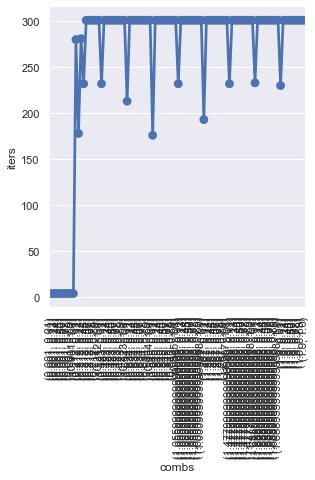

In [538]:
results_adam = pd.DataFrame(results)
plt.figure(figsize=(12, 12))
sns.catplot(data=results_adam, x='combs', y='losses_train', kind="point")
plt.xticks(rotation=90)
min_loss_train = results_adam['losses_train'].min()
best_comb_loss_train = results_adam[results_adam['losses_train'] == min_loss_train]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_adam, x='combs', y='losses_test', kind="point")
plt.xticks(rotation=90)
min_loss_test = results_adam['losses_test'].min()
best_comb_loss_test = results_adam[results_adam['losses_test'] == min_loss_test]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_adam, x='combs', y='R2', kind='point')
plt.xticks(rotation=90)
max_r2 = results_adam['R2'].max()
best_comb_r2 = results_adam[results_adam['R2'] == max_r2]['combs']
plt.figure(figsize=(12, 12))
sns.catplot(data=results_adam, x='combs', y='iters', kind='point')
plt.xticks(rotation=90);

In [539]:
best_comb_loss_train

80    (1.6889999999999998, 0.01)
Name: combs, dtype: object

In [540]:
best_comb_loss_test

80    (1.6889999999999998, 0.01)
Name: combs, dtype: object

In [541]:
best_comb_r2

80    (1.6889999999999998, 0.01)
Name: combs, dtype: object

Для adam лучшая лямбда: 1.7, лучшая mu: 0.01

`### ваше решение тут ###`

## Задание 8. Альтернативная функция потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$

Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент:

$\tanh(wx-y)x$

Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [550]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        if self.loss_function is LossFunction.MSE:
            return (1/x.shape[0])*np.dot((y-np.dot(x, self.w)).T, (y-np.dot(x, self.w)))
        elif self.loss_function is LossFunction.LogCosh:
            return np.log(np.cosh(np.dot(x, self.w)-y))
       
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return np.dot(x, self.w)


class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        diff = - self.lr()*gradient
        self.w = self.w + diff
        return diff
    
    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return -(2/x.shape[0])*np.dot(x.T, (y-np.dot(x, self.w)))
        elif self.loss_function is LossFunction.LogCosh:
            return np.dot(np.tanh(np.dot(x, self.w)-y), x)


class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch_indices = np.random.choice(x.shape[0], size=self.batch_size, replace=False)
        batch = x[batch_indices]
        if self.loss_function is LossFunction.MSE:
            return -(2/batch.shape[0])*np.dot(batch.T, (y[batch_indices]-np.dot(batch, self.w)))
        elif self.loss_function is LossFunction.LogCosh:
            return np.dot(np.tanh(np.dot(batch, self.w)-y[batch_indices]), batch)

In [562]:
best_lambdas

{'full': 1.75, 'stochastic': 0.49, 'momentum': 1.51, 'adam': 62511}

In [593]:
np.random.seed(10)

descent_config = {
    'descent_name': 'name',
    'loss_function': LossFunction.LogCosh,
    'kwargs': {
        'dimension': 321
    }
}

names = ['full', 'stochastic', 'momentum', 'adam']

results_models = {}

for name in names:
    descent_config['descent_name'] = name
    regression = LinearRegression(descent_config)
    regression.fit(x_train, y_train)
    losses = regression.loss_history
    results_models[name] = losses

In [594]:
results_full = pd.Series(results_models['full'])
results_stochastic = pd.Series(results_models['stochastic'])
results_momentum = pd.Series(results_models['momentum'])
results_adam = pd.Series(results_models['adam'])

In [595]:
full_min = results_full.min()
full_iter = results_full[results_full == full_min].index[0]
stochastic_min = results_stochastic.min()
stochastic_iter = results_stochastic[results_stochastic == stochastic_min].index[0]
momentum_min = results_momentum.min()
momentum_iter = results_momentum[results_momentum == momentum_min].index[0]
adam_min = results_adam.min()
adam_iter = results_adam[results_adam == adam_min].index[0]
print(f'full min: {full_min}, iter: {full_iter}')
print(f'stochastic min: {stochastic_min}, iter: {stochastic_iter}')
print(f'momentum min: {momentum_min}, iter: {momentum_iter}')
print(f'adam min: {adam_min}, iter: {adam_iter}')

full min: 15.674681214470924, iter: 2
stochastic min: 27.39339584518701, iter: 3
momentum min: 3.7568606240280213, iter: 57
adam min: 17.272111514365765, iter: 3


In [596]:
full_last = results_full.tail(1).values[0]
stochastic_last = results_stochastic.tail(1).values[0]
momentum_last = results_momentum.tail(1).values[0]
adam_last = results_adam.tail(1).values[0]
full_iters = results_full.shape[0]
stochastic_iters = results_stochastic.shape[0]
momentum_iters = results_momentum.shape[0]
adam_iters = results_adam.shape[0]
print(f'full end loss value: {full_last}, number of iters: {full_iters}')
print(f'stochastic end loss value: {stochastic_last}, number of iters: {stochastic_iters}')
print(f'momentum end loss value: {momentum_last}, number of iters: {momentum_iters}')
print(f'adam end loss value: {adam_last}, number of iters: {adam_iters}')

full end loss value: 15.674681214470924, number of iters: 3
stochastic end loss value: 27.39339584518701, number of iters: 4
momentum end loss value: 3.7568606240280213, number of iters: 58
adam end loss value: 17.272111514365765, number of iters: 4


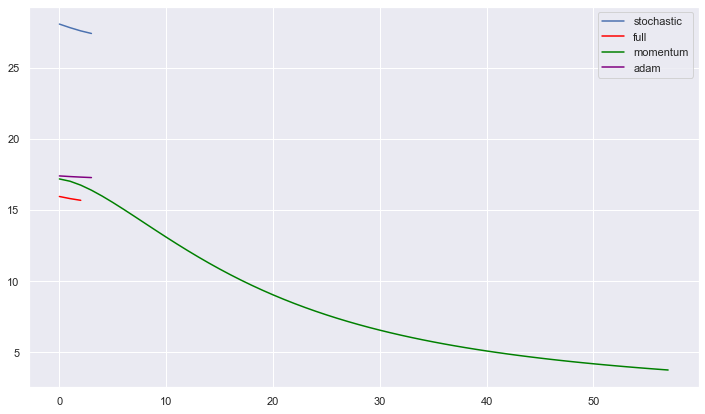

In [597]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=results_stochastic.index, y=results_stochastic.values)
sns.lineplot(x=results_full.index, y=results_full.values, color='red')
sns.lineplot(x=results_momentum.index, y=results_momentum.values, color='green')
sns.lineplot(x=results_adam.index, y=results_adam.values, color='purple')
plt.legend(labels=['stochastic', 'full', 'momentum', 'adam']);

В отличии от модели линейной регрессии с MSE, модель с LogCosh очень быстро сходиться, буквально за несколько итераций, кроме momentum, у которого обучение заняло больше 50 итераций. Однако качество моделей намного хуже, чем у MSE. Если у MSE качество было меньше 1 на всех моделях, то у LogCosh самое высокое качество - это 3.7. Поэтому, если говорить об их различиях, то LogCosh обучается намного быстрее, но хуже по качеству, причем очень сильно. 

### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

`### ваш кулинарный опыт тут ###`

### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AdaMax` (вариация Adam основанная на $l_{\infty}$), `Nadam` (вариация Adam совмещенная с методом импульса Нестерова), `AMSGrad` (ещё одна вариация Adam).

In [ ]:
# YOUR CODE:

### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?

In [ ]:
# YOUR CODE: